In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Dropout, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Should list GPU devices properly
print("TF version:", tf.__version__)
print("Visible GPUs:", tf.config.list_physical_devices('GPU'))

# Run a simple matmul to test GPU usage
with tf.device("/GPU:0"):
    a = tf.random.normal([5000, 5000])
    b = tf.random.normal([5000, 5000])
    c = tf.matmul(a, b)

print("Matmul complete.")


TF version: 2.16.2
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-12-12 14:46:15.977018: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-12-12 14:46:15.977136: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-12 14:46:15.977140: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-12 14:46:15.977345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-12 14:46:15.977363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Matmul complete.


## Loading the Data

In [3]:
# Create a dataframe with 2 columns, one with the file path and one with the label

root_directory = "brain-tumor-mri-dataset"
classes = ["glioma", "meningioma", "notumor", "pituitary"]

rows = []

for label in classes:
    class_directory = os.path.join(root_directory, label)
    for filename in os.listdir(class_directory):
        # Skip hidden files or non-images if needed
        if filename.startswith("."):
            continue
        file_path = os.path.join(class_directory, filename)
        # Add the file path and label to the DataFrame
        df = pd.DataFrame({"file_path": [file_path], "label": [label]})
        # Make sure it's a file (and not a directory)
        if os.path.isfile(file_path):
            rows.append({
                "filepath": file_path,
                "label": label
            })

df = pd.DataFrame(rows, columns=["filepath", "label"])
print(df.head())
print(len(df), "images found")

                                     filepath   label
0  brain-tumor-mri-dataset/glioma/gl-0331.jpg  glioma
1  brain-tumor-mri-dataset/glioma/gl-0457.jpg  glioma
2  brain-tumor-mri-dataset/glioma/gl-0443.jpg  glioma
3  brain-tumor-mri-dataset/glioma/gl-0325.jpg  glioma
4  brain-tumor-mri-dataset/glioma/gl-1013.jpg  glioma
7153 images found


/var/folders/c8/b7s8hxzs2tj76k5vs7x5fxkh0000gn/T/ipykernel_53524/1653505104.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y=df['label'], palette='rocket')


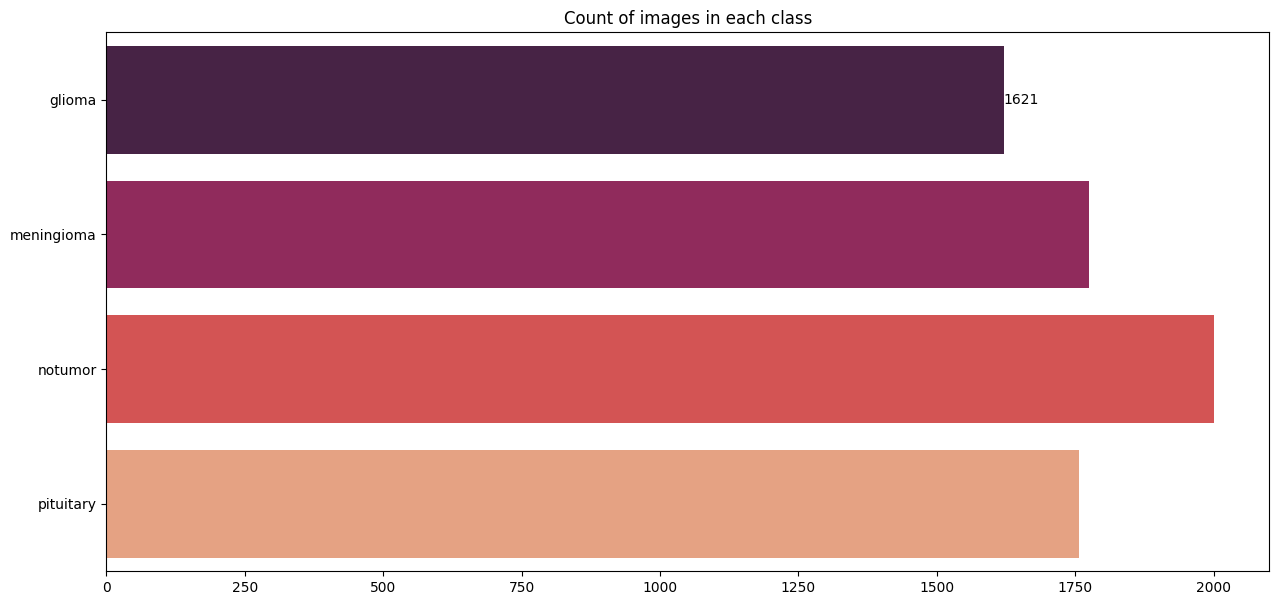

In [4]:
def count_images(df):
  plt.figure(figsize=(15,7))
  ax = sns.countplot(data=df, y=df['label'], palette='rocket')

  plt.xlabel('')
  plt.ylabel('')
  plt.title('Count of images in each class')
  ax.bar_label(ax.containers[0])
  plt.show()

count_images(df)

Train size: 5722 rows
Validation size: 715 rows
Test size: 716 rows


/var/folders/c8/b7s8hxzs2tj76k5vs7x5fxkh0000gn/T/ipykernel_53524/1653505104.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y=df['label'], palette='rocket')


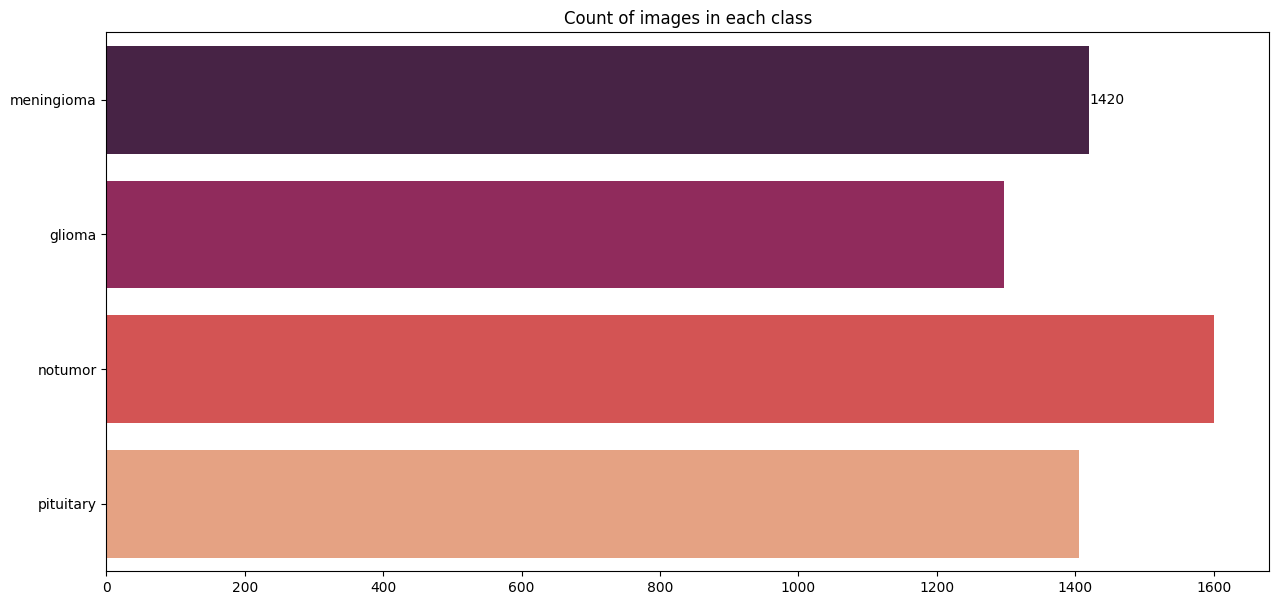

/var/folders/c8/b7s8hxzs2tj76k5vs7x5fxkh0000gn/T/ipykernel_53524/1653505104.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y=df['label'], palette='rocket')


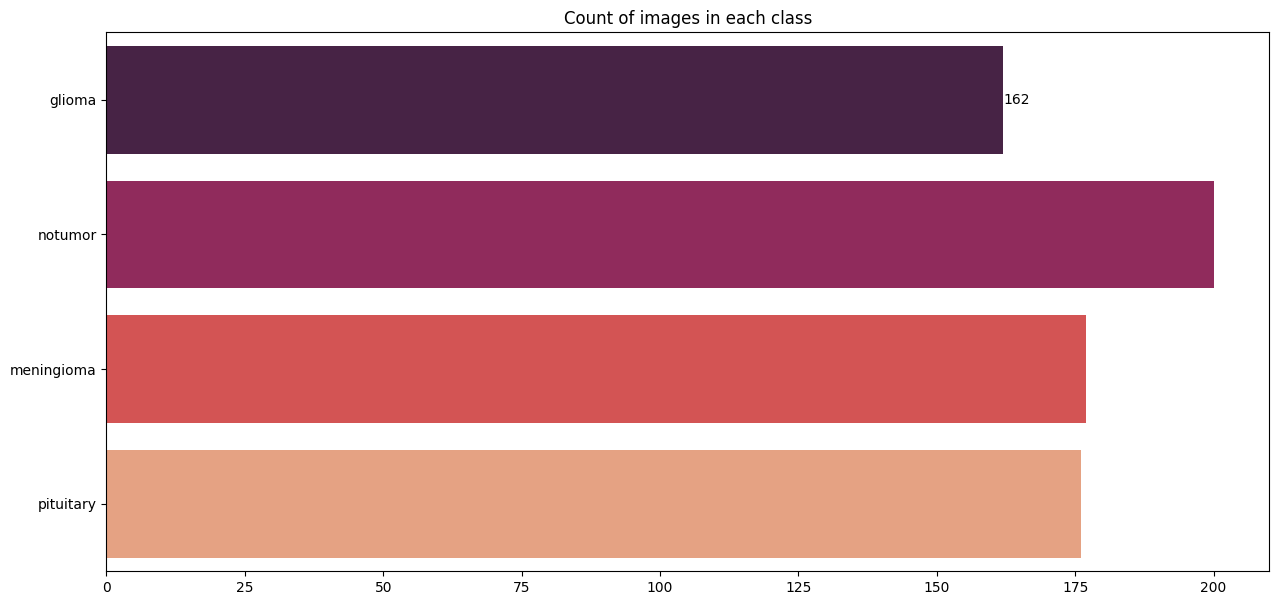

/var/folders/c8/b7s8hxzs2tj76k5vs7x5fxkh0000gn/T/ipykernel_53524/1653505104.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y=df['label'], palette='rocket')


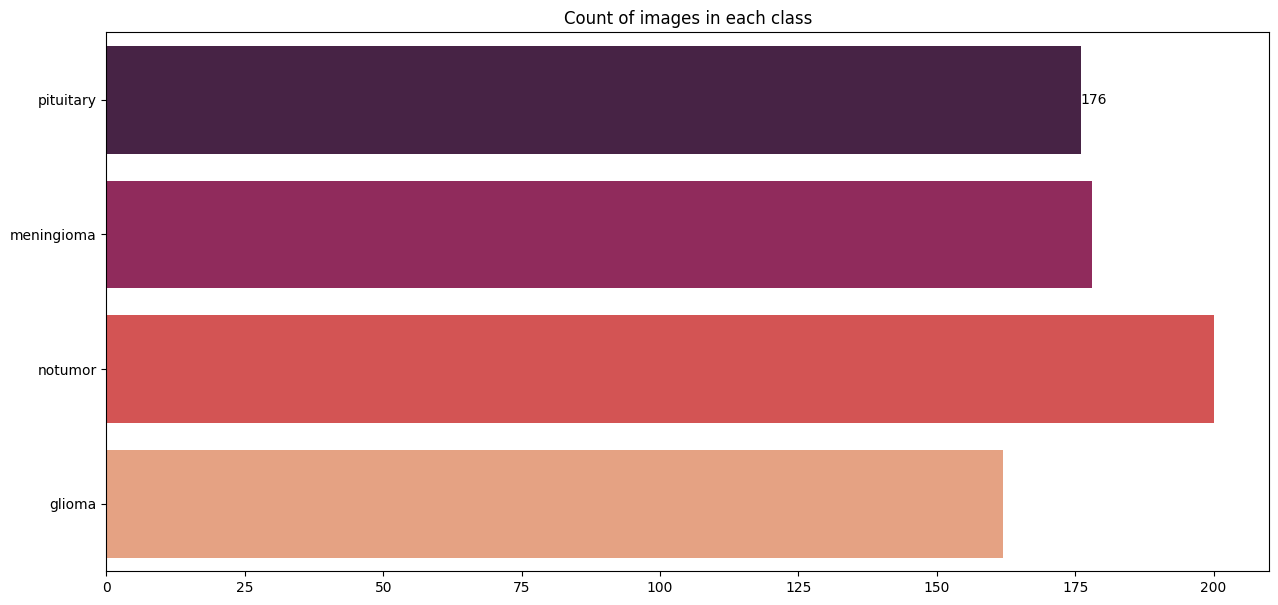

In [5]:
# 80% Training, 10% Validation, 10% Test

# stratify ensures that the split is done in a way that maintains the proportion of classes
train_df, test_val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42, stratify=test_val_df['label'])

print(f"Train size: {len(train_df)} rows")
print(f"Validation size: {len(val_df)} rows")
print(f"Test size: {len(test_df)} rows")

count_images(train_df)
count_images(val_df)
count_images(test_df)

### Data Preprocessing

In [6]:
IMG_SIZE = 299   # Xception default
BATCH_SIZE = 32

# Data generator for training with light augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Xception expects this
    rotation_range=10,                        # small rotations, avoid crazy angles
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1,
    horizontal_flip=False,                   # flipping brains L/R can be misleading
    fill_mode='nearest'
)

# Data generator for validation & test (no augmentation)
test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Train generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",           # MRI is grayscale but this will replicate channels
    class_mode="categorical",   # 4 classes → one-hot
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Validation generator
val_gen = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Test generator
test_gen = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 5722 validated image filenames belonging to 4 classes.
Found 715 validated image filenames belonging to 4 classes.
Found 716 validated image filenames belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


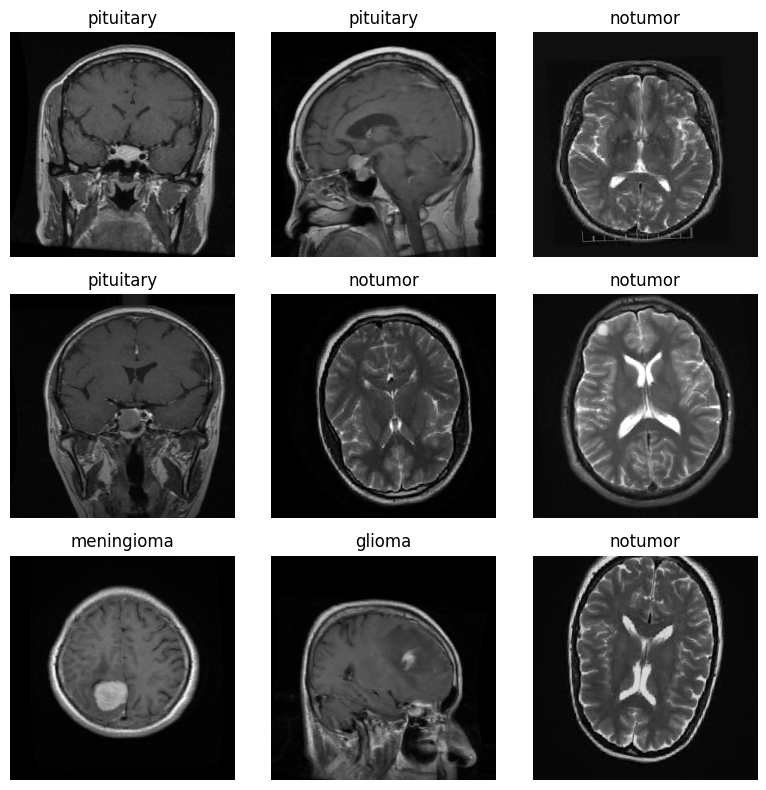

In [7]:
# Grab one batch
images, labels = next(train_gen)

# Map index → class name
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # Xception preprocess_input puts images in [-1, 1], so we un-normalize for display
    img = images[i]
    img_disp = (img + 1.0) / 2.0  # back to [0,1]

    plt.imshow(img_disp)
    label_idx = np.argmax(labels[i])
    plt.title(idx_to_class[label_idx])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
img_shape = (299, 299, 3)

base_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')
# start with frozen base for phase 1 training
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [10]:
# Unfreeze some or all of Xception for fine-tuning
base_model.trainable = True

# (Optional) freeze bottom layers to avoid wrecking low-level features:
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    Adamax(learning_rate=1e-4),   # smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

history_ft = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.6431 - loss: 1.0516 - precision: 0.6828 - recall: 0.5898 - val_accuracy: 0.8699 - val_loss: 0.4007 - val_precision: 0.8914 - val_recall: 0.8378
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.8188 - loss: 0.5254 - precision: 0.8366 - recall: 0.7957 - val_accuracy: 0.8965 - val_loss: 0.2953 - val_precision: 0.9071 - val_recall: 0.8881
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.8593 - loss: 0.3947 - precision: 0.8714 - recall: 0.8481 - val_accuracy: 0.9203 - val_loss: 0.2239 - val_precision: 0.9274 - val_recall: 0.9105
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.8943 - loss: 0.3207 - precision: 0.9012 - recall: 0.8878 - val_accuracy: 0.9385 - val_loss: 0.1830 - val_precision: 0.9396 - val_recall: 0.9357
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.9161 - loss: 0.2574 - precision: 0.9195 - recall: 0.9119 - val_accuracy: 0.9455 - val_los

In [14]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_gen)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 685ms/step - accuracy: 0.9665 - loss: 0.1072 - precision: 0.9665 - recall: 0.9665
Test loss: 0.1072
Test accuracy: 0.9665
Test precision: 0.9665
Test recall: 0.9665


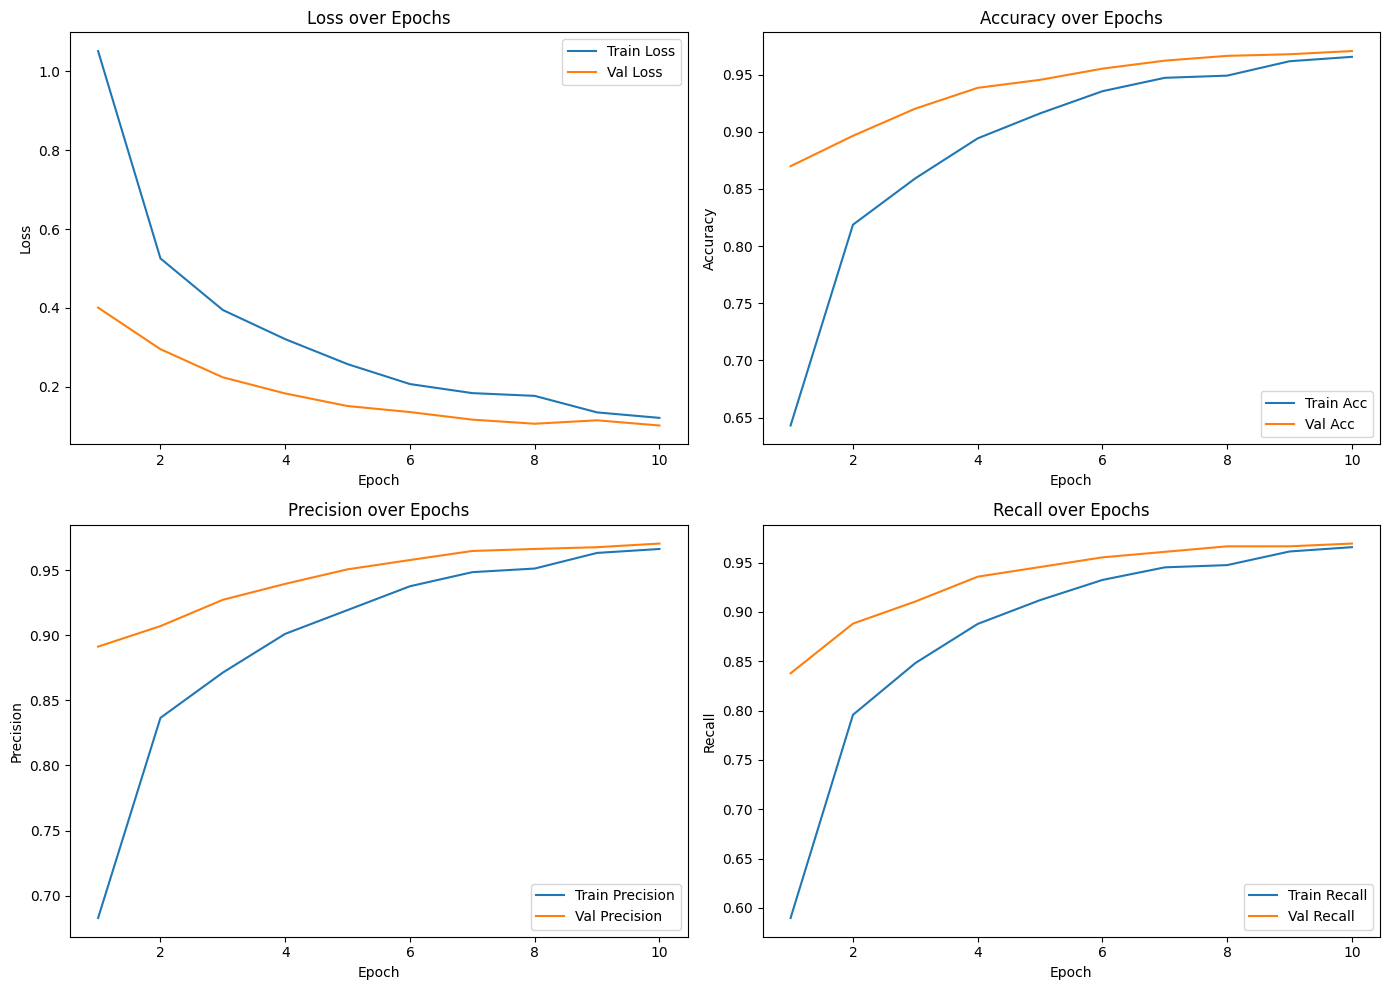

In [11]:
import matplotlib.pyplot as plt

history_dict = history_ft.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(14, 10))

# 1) Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, history_dict['loss'], label='Train Loss')
plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc = "upper right")

# 2) Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, history_dict['accuracy'], label='Train Acc')
plt.plot(epochs, history_dict['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc = "lower right")

# 3) Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, history_dict['precision'], label='Train Precision')
plt.plot(epochs, history_dict['val_precision'], label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend(loc = "lower right")

# 4) Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, history_dict['recall'], label='Train Recall')
plt.plot(epochs, history_dict['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend(loc = "lower right")

plt.tight_layout()
plt.show()


In [12]:
# Save encoder weights (best for initializing the U-Net encoder)
base_model.save_weights("xception_encoder.weights.h5")

# Optional: save the full classifier too
model.save("xception_classifier.keras")


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 716ms/step


<Figure size 700x600 with 0 Axes>

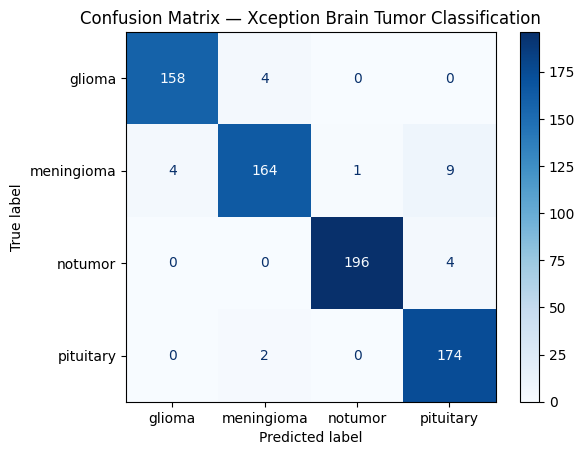

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Ensure generator is not shuffled
test_gen.reset()

# Predict class probabilities
y_pred_probs = model.predict(test_gen, verbose=1)

# Convert probabilities → class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_gen.classes

# Class names (important for correct labeling)
class_names = list(test_gen.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Xception Brain Tumor Classification")
plt.show()


In [22]:
# Build a master table of per-image predictions (TEST set)
test_gen.reset()
probs = model.predict(test_gen, verbose=1)

y_true = test_gen.classes
y_pred = np.argmax(probs, axis=1)
conf = np.max(probs, axis=1)

top2 = np.argsort(probs, axis=1)[:, ::-1][:, :2]
top1_idx = top2[:, 0]
top2_idx = top2[:, 1]
top1_conf = probs[np.arange(len(probs)), top1_idx]
top2_conf = probs[np.arange(len(probs)), top2_idx]
margin = top1_conf - top2_conf

idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

pred_df = test_df.copy().reset_index(drop=True)
pred_df["y_true_idx"] = y_true
pred_df["y_pred_idx"] = y_pred
pred_df["true_label"] = pred_df["label"]
pred_df["pred_label"] = [idx_to_class[i] for i in y_pred]
pred_df["pred_conf"] = conf
pred_df["top2_label"] = [idx_to_class[i] for i in top2_idx]
pred_df["margin"] = margin

# Helpful flags
pred_df["correct"] = pred_df["true_label"] == pred_df["pred_label"]
pred_df.head()

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 668ms/step


,filepath,label,y_true_idx,y_pred_idx,true_label,pred_label,pred_conf,top2_label,margin,correct
0,brain-tumor-mri-dataset/pituitary/pi-1744.jpg,pituitary,3,3,pituitary,pituitary,0.999960,meningioma,0.999923,True
1,brain-tumor-mri-dataset/meningioma/me-0551.jpg,meningioma,1,1,meningioma,meningioma,1.000000,glioma,0.999999,True
2,brain-tumor-mri-dataset/notumor/no-1206.jpg,notumor,2,2,notumor,notumor,1.000000,glioma,1.000000,True
3,brain-tumor-mri-dataset/pituitary/pi-0993.jpg,pituitary,3,3,pituitary,pituitary,0.999978,meningioma,0.999956,True
4,brain-tumor-mri-dataset/glioma/gl-0405.jpg,glioma,0,0,glioma,glioma,0.994016,meningioma,0.988033,True


In [122]:
DATA_ROOT = "brain-tumor-mri-dataset"

# Hand-pick filenames (just the filenames inside each folder)
PICKED = {
    "meningioma": [
        "me-0037.jpg",
        "me-1773.jpg",
        "me-1752.jpg",
    ],
    "glioma": [
        "gl-0076.jpg",
        "gl-1617.jpg",
        "gl-1594.jpg"
    ],
    "pituitary": [
        "pi-0006.jpg",
        "pi-1746.jpg",
        "pi-1734.jpg"
    ]
}

def build_examples_from_filenames(picked_dict, root=DATA_ROOT):
    """
    Returns EXAMPLES dict mapping class -> DataFrame with at least a `filepath` column,
    plus optional metadata fields so your display/loop code doesn't break.
    """
    EXAMPLES = {}
    for cls, fnames in picked_dict.items():
        rows = []
        for f in fnames:
            path = os.path.join(root, cls, f)
            rows.append({
                "filepath": path,
                "true_label": cls,
                # dummy fields so your title string still works
                "pred_label": cls,
                "pred_conf": 1.0,
                "top2_label": cls,
                "margin": 1.0,
                "correct": True,
            })
        EXAMPLES[cls] = pd.DataFrame(rows)
    return EXAMPLES

EXAMPLES = build_examples_from_filenames(PICKED)

for cls, ex in EXAMPLES.items():
    print("\n==", cls, "==")
    display(ex[["filepath", "true_label"]])



== meningioma ==


,filepath,true_label
0,brain-tumor-mri-dataset/meningioma/me-0037.jpg,meningioma
1,brain-tumor-mri-dataset/meningioma/me-1773.jpg,meningioma
2,brain-tumor-mri-dataset/meningioma/me-1752.jpg,meningioma



== glioma ==


,filepath,true_label
0,brain-tumor-mri-dataset/glioma/gl-0076.jpg,glioma
1,brain-tumor-mri-dataset/glioma/gl-1617.jpg,glioma
2,brain-tumor-mri-dataset/glioma/gl-1594.jpg,glioma



== pituitary ==


,filepath,true_label
0,brain-tumor-mri-dataset/pituitary/pi-0006.jpg,pituitary
1,brain-tumor-mri-dataset/pituitary/pi-1746.jpg,pituitary
2,brain-tumor-mri-dataset/pituitary/pi-1734.jpg,pituitary


In [126]:
import cv2
import math

def load_mri_gray(path):
    """Load image as grayscale float32 in [0,1]."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read: {path}")
    img = img.astype(np.float32) / 255.0
    return img

def clahe01(img01, clip=2.0, tile=(8,8)):
    """CLAHE on [0,1] image -> [0,1]."""
    u8 = np.clip(img01 * 255.0, 0, 255).astype(np.uint8)
    c = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    out = c.apply(u8).astype(np.float32) / 255.0
    return out

def overlay_outline(gray01, mask01, thickness=2):
    """Return RGB overlay with red contour on grayscale."""
    base = (np.clip(gray01, 0, 1) * 255).astype(np.uint8)
    rgb = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
    mask_u8 = (mask01 > 0).astype(np.uint8)

    # find contours
    cnts, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(rgb, cnts, -1, (0, 0, 255), thickness)
    return rgb

def show_triplet(gray01, mask01, title=""):
    """Show original, mask, overlay."""
    overlay = overlay_outline(gray01, mask01)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(gray01, cmap="gray"); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask01, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay[..., ::-1]); plt.title("Overlay"); plt.axis("off")  # BGR->RGB
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def _solidity(contour):
    """
    Area / convex-hull-area. Thin arcs (like skull fragments) tend to have low solidity.
    """
    area = cv2.contourArea(contour)
    if area <= 1e-6:
        return 0.0
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    if hull_area <= 1e-6:
        return 0.0
    return float(area / hull_area)

def _component_stats(bin_u8):
    """Return list of (label_id, area, cx, cy) for connected components (excluding background)."""
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_u8, connectivity=8)
    comps = []
    for i in range(1, num):
        area = stats[i, cv2.CC_STAT_AREA]
        cx, cy = centroids[i]
        comps.append((i, area, cx, cy, labels, stats))
    return comps

def _circularity(contour):
    """4πA / P^2 (1.0 = perfect circle)."""
    area = cv2.contourArea(contour)
    per = cv2.arcLength(contour, True)
    if per <= 1e-6:
        return 0.0
    return float(4.0 * math.pi * area / (per * per))


In [136]:
def _segment_in_roi(
    gray01,
    roi,
    debug=False,
    # --- parameters you can tune ---
    clahe_clip=2.8,
    blur_ksize=5,
    median_ksize=3,
    bilateral_d=7,
    bilateral_sigma_color=35,
    bilateral_sigma_space=35,
    tophat_ksize=17,      # emphasize small bright blobs
    q_seed=94,            # strict seed threshold percentile (92–97)
    q_grow=86,            # relaxed grow percentile (80–90)
    grow_dilate=1,        # thicken seed so it intersects grow region (0–3)
    close_ksize=5,
    open_ksize=3,
    min_area_frac=0.0004, # small! (try 0.0002–0.001)
    max_area_frac=0.08,   # pit tumors usually not huge in ROI (0.05–0.12)
    min_circ=0.35,        # circularity threshold (0.25–0.55)
    min_sol=0.70,         # solidity threshold (0.60–0.85)
    w_contrast=5.0,
    w_circ=2.0,
    w_sol=2.0,
    w_dist=2.0
):
    """
    Segment pituitary candidate inside ROI.
    Uses: denoise -> CLAHE -> top-hat -> seed+grow -> score components.

    roi = (x0, y0, x1, y1) normalized coords.
    Returns: full_mask (uint8 0/1), score (float), debug_dict
    """
    h, w = gray01.shape
    x0 = int(roi[0] * w); y0 = int(roi[1] * h)
    x1 = int(roi[2] * w); y1 = int(roi[3] * h)
    x0, y0 = max(0, x0), max(0, y0)
    x1, y1 = min(w, x1), min(h, y1)

    patch = gray01[y0:y1, x0:x1]
    if patch.size == 0:
        return np.zeros_like(gray01, dtype=np.uint8), -1e9, {"reason": "empty_patch"}

    # ----------------------------
    # 1) Preprocess / denoise
    # ----------------------------
    p = clahe01(patch, clip=clahe_clip, tile=(8, 8))

    # Median kills salt/pepper speckle; bilateral smooths while keeping edges
    if median_ksize >= 3:
        p = cv2.medianBlur((p * 255).astype(np.uint8), median_ksize).astype(np.float32) / 255.0

    p_u8 = (np.clip(p, 0, 1) * 255).astype(np.uint8)
    p_u8 = cv2.bilateralFilter(
        p_u8,
        d=bilateral_d,
        sigmaColor=bilateral_sigma_color,
        sigmaSpace=bilateral_sigma_space
    )

    # light Gaussian
    if blur_ksize >= 3 and blur_ksize % 2 == 1:
        p_u8 = cv2.GaussianBlur(p_u8, (blur_ksize, blur_ksize), 0)

    p = p_u8.astype(np.float32) / 255.0

    # ----------------------------
    # 2) Top-hat to emphasize small bright blobs
    # ----------------------------
    k_th = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (tophat_ksize, tophat_ksize))
    tophat = cv2.morphologyEx((p * 255).astype(np.uint8), cv2.MORPH_TOPHAT, k_th)
    t = tophat.astype(np.float32) / 255.0  # "blobness" image

    # ----------------------------
    # 3) Seed + grow thresholds on top-hat response
    # ----------------------------
    # If t is very low everywhere (rare), fallback to using p
    # If t is very low everywhere (rare), fallback to using p
    # Seed on top-hat (better localization), grow on p (better coverage)
    seed_base = t if np.max(t) > 1e-3 else p
    grow_base = p  # IMPORTANT: expand on the denoised CLAHE image

    seed_thr = np.percentile(seed_base, q_seed)
    grow_thr = np.percentile(grow_base, q_grow)

    seed = (seed_base >= seed_thr).astype(np.uint8)
    grow = (grow_base >= grow_thr).astype(np.uint8)


    # Morph cleanup on grow
    k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ksize, open_ksize))
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ksize, close_ksize))
    grow = cv2.morphologyEx(grow, cv2.MORPH_OPEN, k_open, iterations=1)
    grow = cv2.morphologyEx(grow, cv2.MORPH_CLOSE, k_close, iterations=2)

    # Thicken seed so it intersects grow region
    if grow_dilate > 0:
        k_seed = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        seed = cv2.dilate(seed, k_seed, iterations=grow_dilate)

    # Keep only parts of "grow" that connect to "seed"
    numG, labG = cv2.connectedComponents(grow, connectivity=8)
    if numG <= 1:
        return np.zeros_like(gray01, dtype=np.uint8), -1e9, {"reason": "no_components_after_grow"}

    touched = np.unique(labG[seed > 0])
    touched = touched[touched != 0]
    if touched.size == 0:
        return np.zeros_like(gray01, dtype=np.uint8), -1e9, {"reason": "seed_did_not_touch_grow"}

    thr = np.isin(labG, touched).astype(np.uint8)

    # ----------------------------
    # 4) Score connected components
    # ----------------------------
    comps = _component_stats(thr.astype(np.uint8))
    if not comps:
        return np.zeros_like(gray01, dtype=np.uint8), -1e9, {"reason": "no_components"}

    pcx = (x1 - x0) / 2.0
    pcy = (y1 - y0) / 2.0
    patch_area = float((y1 - y0) * (x1 - x0))

    best = None
    best_score = -1e9
    best_meta = None

    for (i, area, cx, cy, labels, stats) in comps:
        area_frac = area / max(1.0, patch_area)
        if area_frac < min_area_frac or area_frac > max_area_frac:
            continue

        comp_mask = (labels == i).astype(np.uint8)
        cnts, _ = cv2.findContours(comp_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            continue
        cnt = max(cnts, key=cv2.contourArea)

        circ = _circularity(cnt)
        if circ < min_circ:
            continue

        sol = _solidity(cnt)
        if sol < min_sol:
            continue

        # distance to ROI center (normalized)
        dist = math.sqrt(((cx - pcx) / max(1.0, (x1 - x0)))**2 + ((cy - pcy) / max(1.0, (y1 - y0)))**2)

        # contrast measured on original enhanced patch (p)
        inside = p[comp_mask > 0]
        outside = p[comp_mask == 0]
        if inside.size == 0 or outside.size == 0:
            continue
        contrast = float(np.mean(inside) - np.mean(outside))

        score = (w_contrast * contrast) + (w_circ * circ) + (w_sol * sol) - (w_dist * dist)

        if score > best_score:
            best_score = score
            best = comp_mask
            best_meta = {
                "area_frac": float(area_frac),
                "circ": float(circ),
                "sol": float(sol),
                "dist": float(dist),
                "contrast": float(contrast),
            }

    if best is None:
        return np.zeros_like(gray01, dtype=np.uint8), -1e9, {"reason": "no_plausible_component"}

    full = np.zeros_like(gray01, dtype=np.uint8)
    full[y0:y1, x0:x1] = best

    info = {
        "roi": roi,
        "best_score": float(best_score),
        "meta": best_meta,
        "seed_thr": float(seed_thr),
        "grow_thr": float(grow_thr),
    }

    if debug:
        info["q_seed"] = q_seed
        info["q_grow"] = q_grow

    return full, float(best_score), info


def segment_pituitary(
    gray01,
    min_score=0.25,
    debug=False,
    rois=None,
    **roi_kwargs
):
    """
    Multi-ROI pituitary segmentation.
    Returns mask (0/1 uint8). If best score < min_score, returns empty mask.
    Pass tuning knobs via **roi_kwargs (q_seed, q_grow, tophat_ksize, etc.)
    """
    if rois is None:
        rois = [
            (0.35, 0.30, 0.65, 0.60),  # axial-ish central
            (0.30, 0.45, 0.70, 0.82),  # coronal-ish lower center
            (0.20, 0.30, 0.80, 0.85),  # sagittal-ish wide + lower
        ]

    best_mask = np.zeros_like(gray01, dtype=np.uint8)
    best_score = -1e9
    best_info = None

    for roi in rois:
        m, s, info = _segment_in_roi(gray01, roi, debug=debug, **roi_kwargs)
        if s > best_score:
            best_score = s
            best_mask = m
            best_info = info

    if best_score < min_score:
        if debug:
            print("Pituitary: no confident blob found. best_score =", best_score, "info =", best_info)
        return np.zeros_like(gray01, dtype=np.uint8)

    if debug:
        print("Pituitary: best_score =", best_score, "info =", best_info)

    return best_mask


Pituitary: best_score = 4.583100894511004 info = {'roi': (0.2, 0.3, 0.8, 0.85), 'best_score': 4.583100894511004, 'meta': {'area_frac': 0.03404024302908495, 'circ': 0.7564489795481177, 'sol': 0.9529136750709635, 'dist': 0.11915823223445195, 'contrast': 0.280538409948349}, 'seed_thr': 0.14509804546833038, 'grow_thr': 0.501960813999176, 'q_seed': 94, 'q_grow': 86}


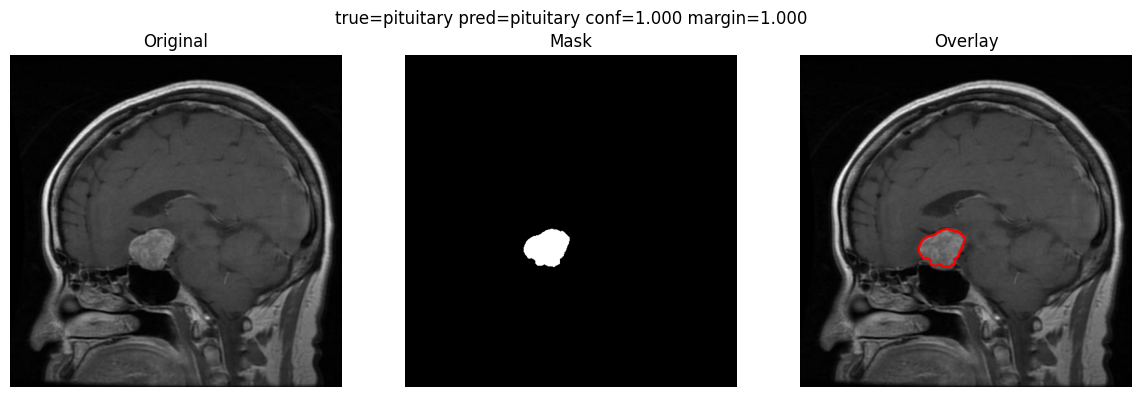

Pituitary: best_score = 4.535291030726996 info = {'roi': (0.2, 0.3, 0.8, 0.85), 'best_score': 4.535291030726996, 'meta': {'area_frac': 0.01811167325062952, 'circ': 0.8219215498295955, 'sol': 0.9640564826700898, 'dist': 0.274892410625071, 'contrast': 0.3026239573955536}, 'seed_thr': 0.13725490868091583, 'grow_thr': 0.5333333611488342, 'q_seed': 94, 'q_grow': 86}


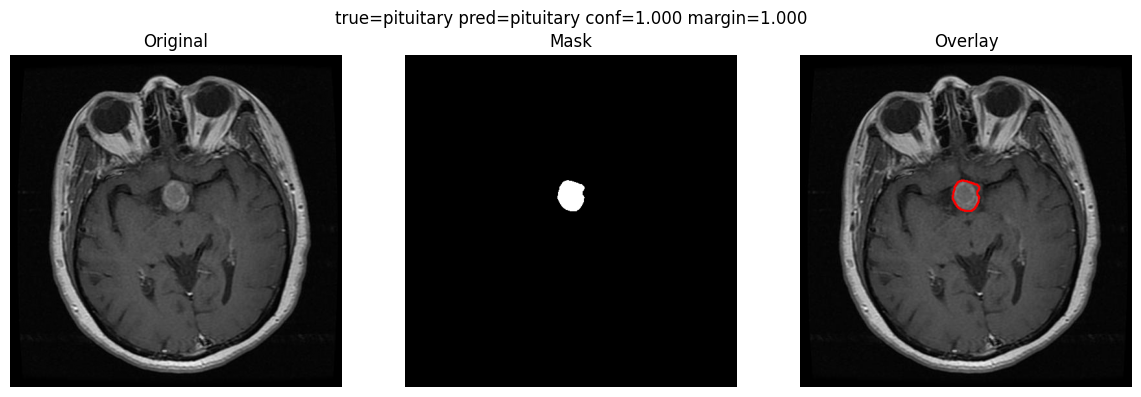

Pituitary: best_score = 4.755689302899995 info = {'roi': (0.2, 0.3, 0.8, 0.85), 'best_score': 4.755689302899995, 'meta': {'area_frac': 0.029985908009333057, 'circ': 0.8812500168378199, 'sol': 0.9851097178683386, 'dist': 0.28089259988347215, 'contrast': 0.3169510066509247}, 'seed_thr': 0.11372549086809158, 'grow_thr': 0.5254902243614197, 'q_seed': 94, 'q_grow': 86}


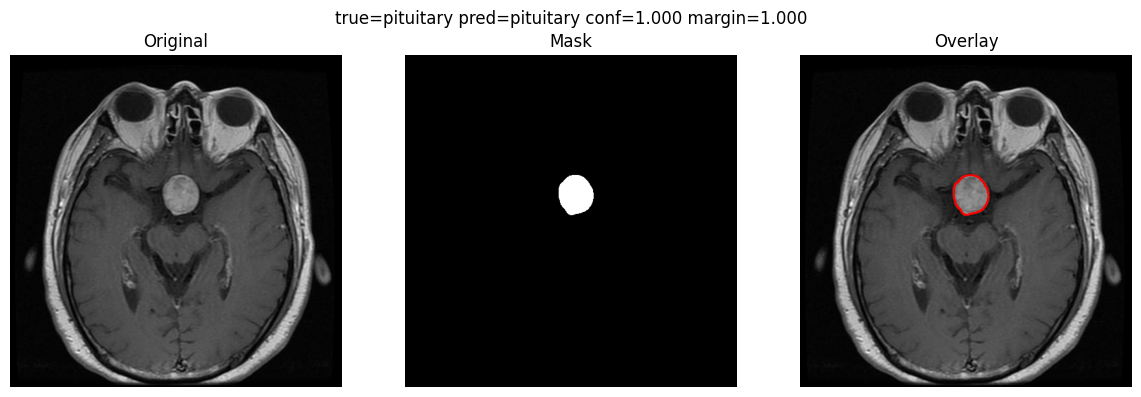

In [137]:
# Visual test on the pituitary example set
pit_df = EXAMPLES["pituitary"]

for _, row in pit_df.iterrows():
    path = row["filepath"]
    gray = load_mri_gray(path)
    mask = segment_pituitary(gray, min_score=0.35, debug=True)

    title = f"true={row['true_label']} pred={row['pred_label']} conf={row['pred_conf']:.3f} margin={row['margin']:.3f}"
    show_triplet(gray, mask, title=title)

# Meningioma

In [ ]:
def brain_mask(gray01):
    """
    Head/brain-ish mask to suppress background.
    Keep it gentle so extra-axial tumors near boundary aren't erased.
    Returns uint8 mask (0/1).
    """
    g = (np.clip(gray01, 0, 1) * 255).astype(np.uint8)
    g_blur = cv2.GaussianBlur(g, (7,7), 0)

    _, th = cv2.threshold(g_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, k, iterations=2)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN,  k, iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats((th > 0).astype(np.uint8), connectivity=8)
    if num <= 1:
        return np.zeros_like(g, dtype=np.uint8)

    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    head = (labels == largest).astype(np.uint8)

    # Very light erosion (or set iterations=0 if it hurts boundary tumors)
    k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    head = cv2.erode(head, k2, iterations=1)

    return head


def segment_meningioma(
    gray01,
    debug=False,
    clahe_clip=2.6,
    qA=90,          # percentile for main head brightness threshold
    qB=88,          # percentile for rim brightness threshold
    rim_ksize=15,   # controls how "near boundary" is defined
    close_ksize=9,
    open_ksize=9,
    min_area_frac=0.0015,
    max_area_frac=0.50,
    min_solidity=0.65,   # --- Change (1): NEW knob ---
):
    bm = brain_mask(gray01)
    if bm.sum() == 0:
        return np.zeros_like(bm)

    # --- Change (2): distance-to-boundary map (NEW) ---
    # 0 at the boundary of the head mask, larger toward the interior.
    dist = cv2.distanceTransform((bm > 0).astype(np.uint8), cv2.DIST_L2, 5)
    dist = dist / (dist.max() + 1e-6)  # normalize to ~[0,1]

    g = clahe01(gray01, clip=clahe_clip, tile=(8,8))
    g = cv2.GaussianBlur(g, (5,5), 0)

    vals = g[bm > 0]
    if vals.size == 0:
        return np.zeros_like(bm)

    # Candidate A: bright in head
    thrA = np.percentile(vals, qA)
    candA = ((g >= thrA) & (bm > 0)).astype(np.uint8)

    # Candidate B: bright near inner boundary (extra-axial friendly)
    k_rim = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (rim_ksize, rim_ksize))
    inner = cv2.erode(bm, k_rim, iterations=1)
    rim = ((bm > 0) & (inner == 0)).astype(np.uint8)

    thrB = np.percentile(vals, qB)
    candB = ((g >= thrB) & (rim > 0)).astype(np.uint8)

    thr = ((candA > 0) | (candB > 0)).astype(np.uint8)

    # Morph cleanup
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ksize, close_ksize))
    k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ksize, open_ksize))
    thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, k_close, iterations=2)
    thr = cv2.morphologyEx(thr, cv2.MORPH_OPEN,  k_open,  iterations=1)

    comps = _component_stats(thr.astype(np.uint8))
    if not comps:
        if debug:
            print("No components after threshold+cleanup.")
        return np.zeros_like(bm)

    best_mask = None
    best_score = -1e9
    best_meta = None
    head_area = float(np.sum(bm > 0))

    for (i, area, cx, cy, labels, stats) in comps:
        comp = (labels == i).astype(np.uint8)

        area_frac = area / max(1.0, head_area)
        if area_frac < min_area_frac or area_frac > max_area_frac:
            continue

        cnts, _ = cv2.findContours(comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            continue
        cnt = max(cnts, key=cv2.contourArea)

        circ = _circularity(cnt)

        # --- Change (1): compute solidity and reject thin arcs (NEW) ---
        sol = _solidity(cnt)
        if sol < min_solidity:
            continue

        inside = g[comp > 0]
        outside = g[(bm > 0) & (comp == 0)]
        if inside.size == 0 or outside.size == 0:
            continue

        contrast = float(np.mean(inside) - np.mean(outside))
        mean_in = float(np.mean(inside))

        rim_contact = float(np.sum((comp > 0) & (rim > 0))) / max(1.0, np.sum(comp > 0))

        # --- Change (2): compute mean distance to boundary (NEW) ---
        mean_dist = float(np.mean(dist[comp > 0]))  # skull fragments tend to be very close to boundary

        x, y, ww, hh = cv2.boundingRect(cnt)
        aspect = max(ww, hh) / max(1, min(ww, hh))

        # --- Change (1) + (2): updated scoring ---
        # - Reward: size, contrast, brightness, circularity, solidity, being more interior (mean_dist)
        # - Penalize: hugging rim (skull fragments), weird aspect ratio
        score = (
            (8.0 * area_frac) +
            (3.0 * contrast) +
            (1.0 * mean_in) +
            (2.0 * circ) +
            (1.0 * sol) +
            (2.0 * mean_dist) -
            (1.5 * rim_contact) -
            (0.25 * (aspect - 1.0))
        )

        # Optional guard: if it hugs rim a lot, require it to be pretty solid/large
        if rim_contact > 0.50 and (area_frac < 0.010 or sol < 0.80):
            continue

        if score > best_score:
            best_score = score
            best_mask = comp
            best_meta = {
                "area_frac": float(area_frac),
                "contrast": float(contrast),
                "mean_in": float(mean_in),
                "rim_contact": float(rim_contact),
                "mean_dist": float(mean_dist),  # --- Change (2): NEW ---
                "circ": float(circ),
                "sol": float(sol),              # --- Change (1): NEW ---
                "aspect": float(aspect),
            }

    if best_mask is None:
        if debug:
            print("No plausible component. Try lowering qA/qB or min_area_frac.")
        return np.zeros_like(bm)

    # Final fill/smooth
    k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    best_mask = cv2.morphologyEx(best_mask, cv2.MORPH_CLOSE, k3, iterations=2)

    if debug:
        print("Meningioma meta:", best_meta, "best_score:", best_score)
        show_triplet(g, thr, title=f"DEBUG thr (qA={qA}, qB={qB}, rim_ksize={rim_ksize})")

    return best_mask.astype(np.uint8)


Meningioma meta: {'area_frac': 0.0038825803726627354, 'contrast': 0.28394073247909546, 'mean_in': 0.7856206297874451, 'rim_contact': 0.0, 'mean_dist': 0.667090892791748, 'circ': 0.41793964362898384, 'sol': 0.7662801070472792, 'aspect': 1.1176470588235294} best_score: 4.575432885388894


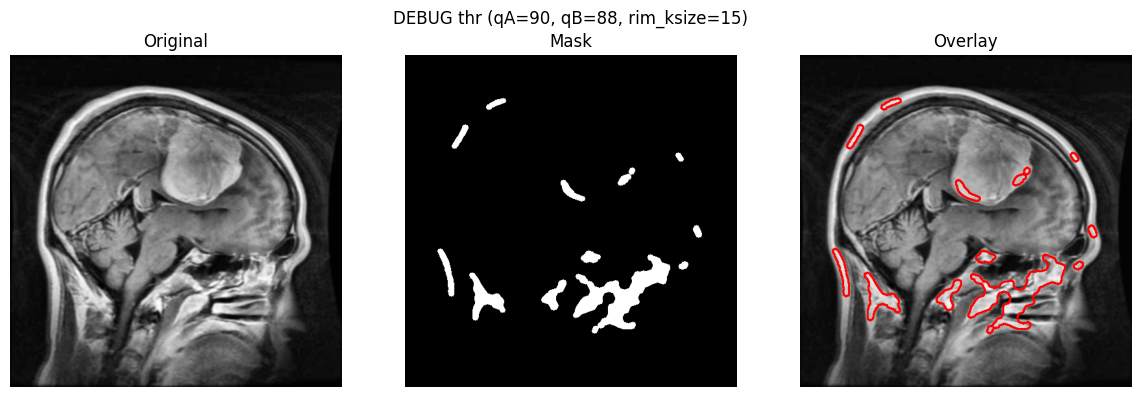

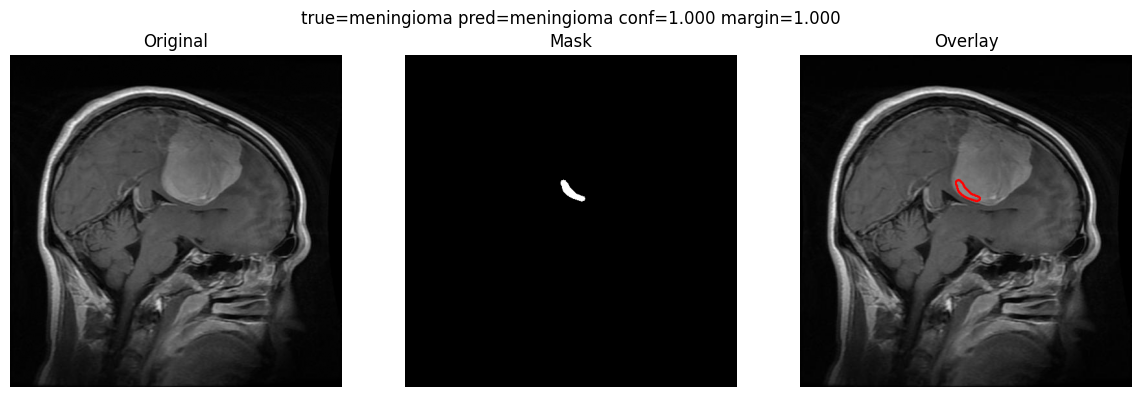

Meningioma meta: {'area_frac': 0.014167540245155532, 'contrast': 0.28176409006118774, 'mean_in': 0.7423762679100037, 'rim_contact': 0.0, 'mean_dist': 0.3533388376235962, 'circ': 0.37613972246291116, 'sol': 0.6619022869022869, 'aspect': 1.1666666666666667} best_score: 3.780201600463446


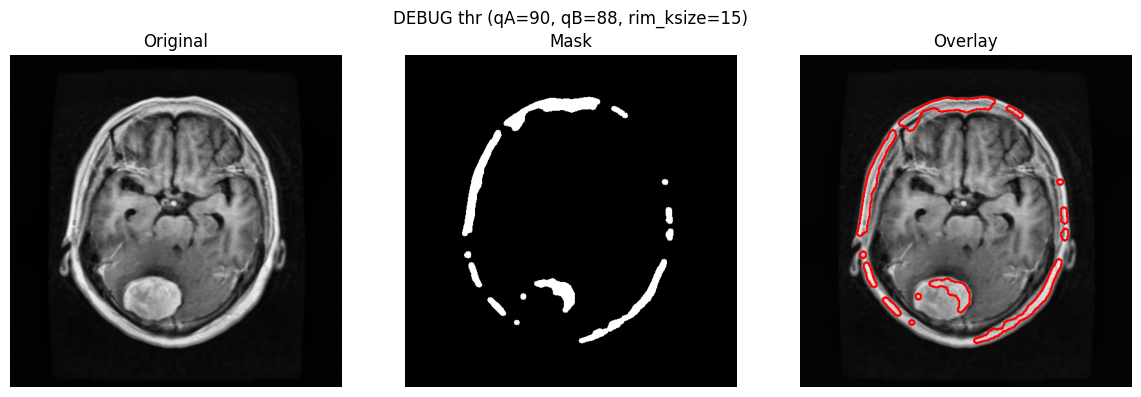

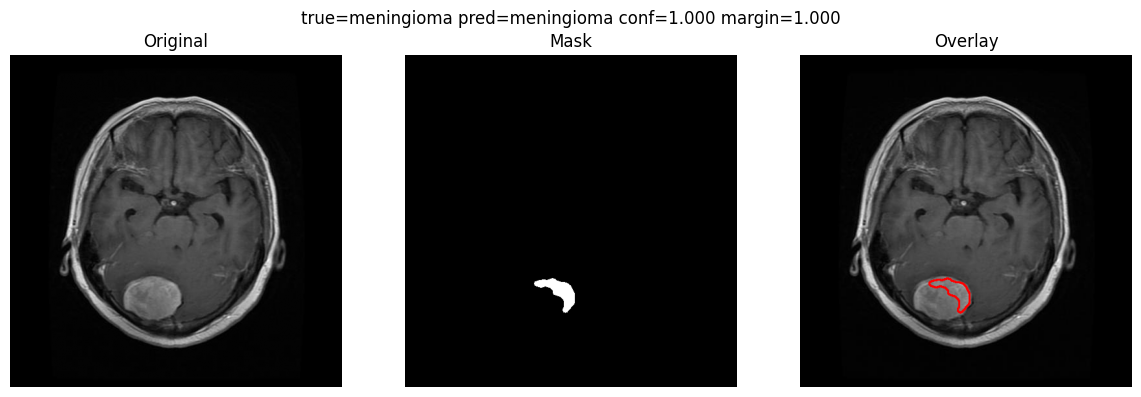

Meningioma meta: {'area_frac': 0.045647343970914966, 'contrast': 0.41124165058135986, 'mean_in': 0.9232288599014282, 'rim_contact': 0.08533501896333755, 'mean_dist': 0.3445890247821808, 'circ': 0.5532668016069764, 'sol': 0.8408517792098628, 'aspect': 1.2340425531914894} best_score: 4.972182828658126


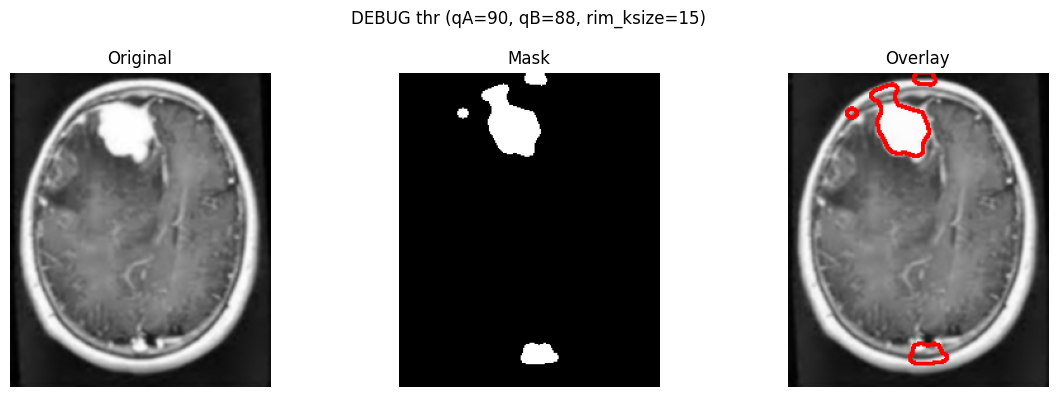

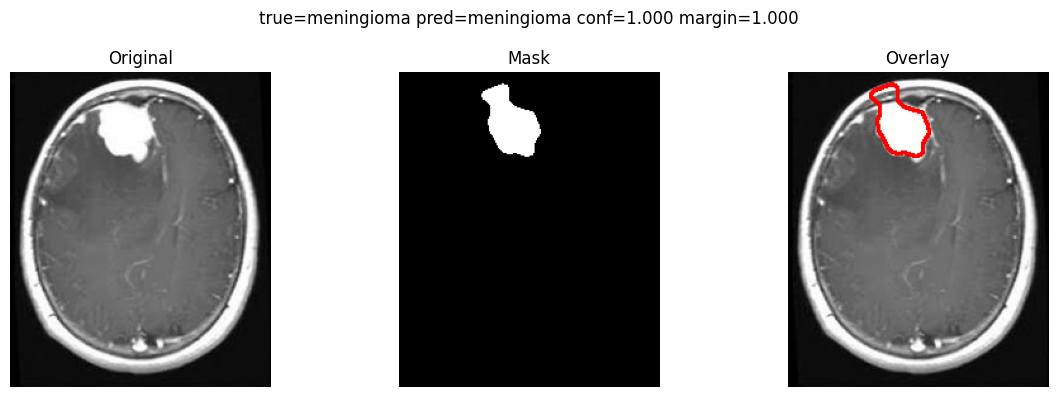

In [115]:
men_df = EXAMPLES["meningioma"]

for _, row in men_df.iterrows():
    path = row["filepath"]
    gray = load_mri_gray(path)

    mask = segment_meningioma(gray, debug=True)

    title = f"true={row['true_label']} pred={row['pred_label']} conf={row['pred_conf']:.3f} margin={row['margin']:.3f}"
    show_triplet(gray, mask, title=title)


# Glioma

Glioma meta: {'area_frac': 0.017212826387280014, 'dark_contrast': 0.2886255979537964, 'rim_score': 0.10271014273166656, 'dist_center': 0.14966946392215635} best_score: 0.9828500906375178


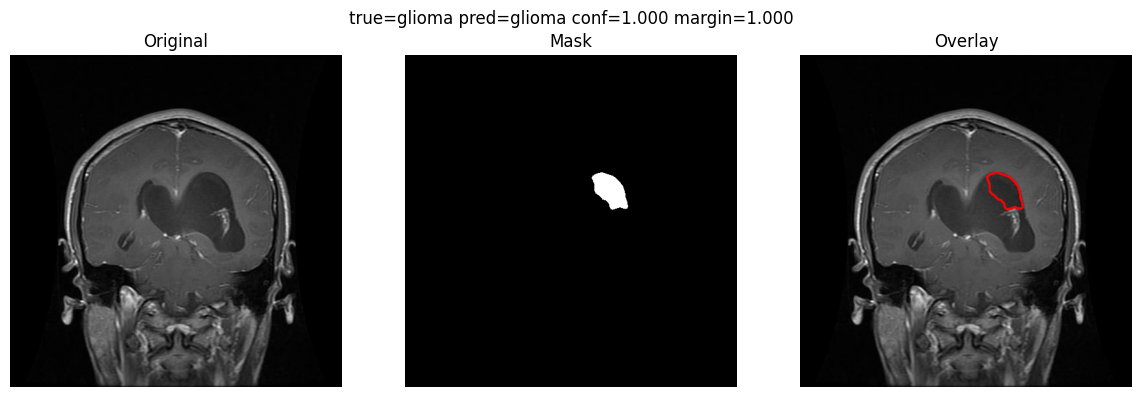

Glioma meta: {'area_frac': 0.016109795086719565, 'dark_contrast': 0.26661938428878784, 'rim_score': 0.149858295917511, 'dist_center': 0.1766967017416773} best_score: 1.0328320490355958


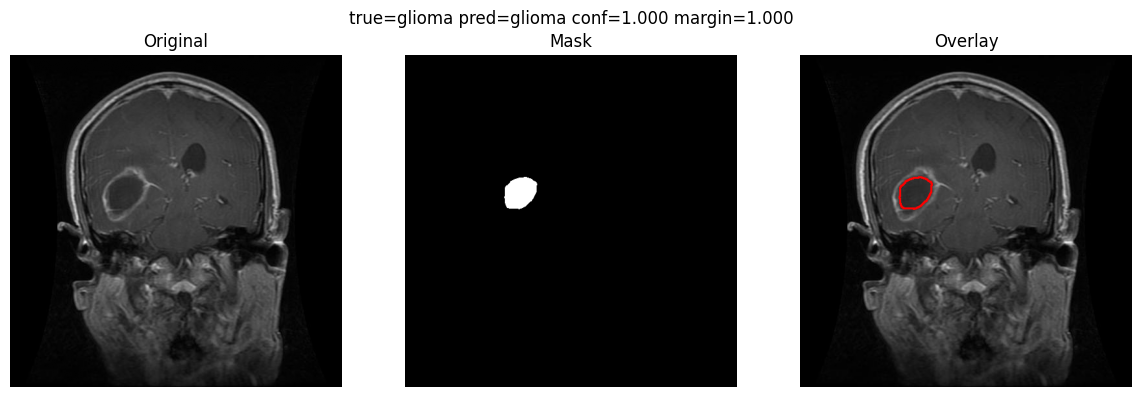

Glioma meta: {'area_frac': 0.007567930994900051, 'dark_contrast': 0.23956450819969177, 'rim_score': 0.1018543541431427, 'dist_center': 0.19376987378782803} best_score: 0.8367215580327119


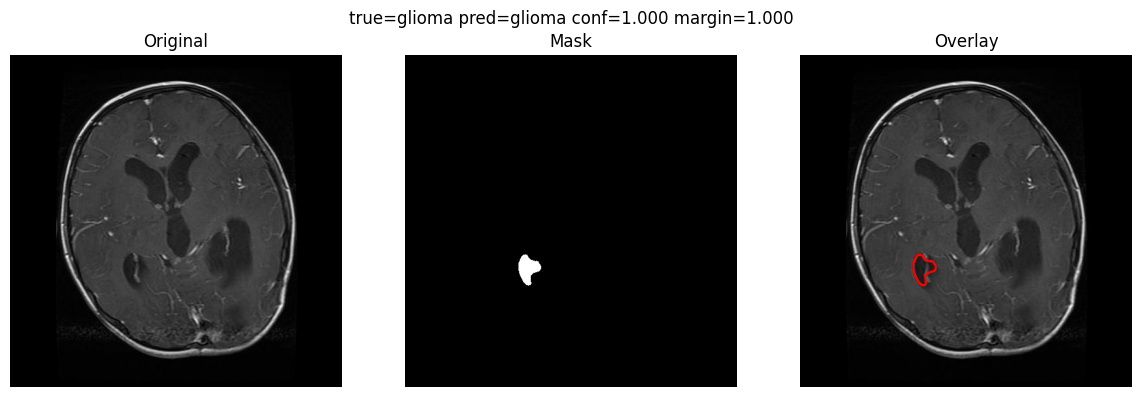

In [117]:
def rim_evidence_score(gray01, comp_mask, brain_mask_u8):
    """
    Measures how much brighter the boundary neighborhood is than the inside.
    For ring-enhancing gliomas, boundary tends to be bright.
    Returns a float (higher = stronger rim).
    """
    comp = (comp_mask > 0).astype(np.uint8)
    if comp.sum() == 0:
        return 0.0

    # boundary band = dilated - eroded
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    dil = cv2.dilate(comp, k, iterations=1)
    ero = cv2.erode(comp, k, iterations=1)
    band = ((dil > 0) & (ero == 0) & (brain_mask_u8 > 0))

    inside = gray01[(comp > 0)]
    rim = gray01[band]

    if inside.size < 20 or rim.size < 20:
        return 0.0

    return float(np.mean(rim) - np.mean(inside))

def segment_glioma(gray01, debug=False):
    """
    Classical glioma segmentation:
    - uses dark-core + bright-rim cues
    - picks best component by size + rim evidence + contrast
    Returns uint8 mask (0/1).
    """
    bm = brain_mask(gray01)  # head-ish mask (should NOT over-erode)
    if bm.sum() == 0:
        return np.zeros_like(bm)

    g = clahe01(gray01, clip=2.6, tile=(8,8))
    g = cv2.GaussianBlur(g, (5,5), 0)

    vals = g[bm > 0]
    if vals.size == 0:
        return np.zeros_like(bm)

    # Dark-core threshold (glioma core often darker)
    q_dark = np.percentile(vals, 12)   # tune 8-18
    dark = ((g <= q_dark) & (bm > 0)).astype(np.uint8)

    # Bright-rim threshold (sometimes ring-enhancing)
    q_bright = np.percentile(vals, 94) # tune 92-97
    bright = ((g >= q_bright) & (bm > 0)).astype(np.uint8)

    # Clean dark regions (remove specks, fill)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    dark = cv2.morphologyEx(dark, cv2.MORPH_OPEN,  k, iterations=1)
    dark = cv2.morphologyEx(dark, cv2.MORPH_CLOSE, k, iterations=2)

    comps = _component_stats(dark.astype(np.uint8))
    if not comps:
        return np.zeros_like(bm)

    best = None
    best_score = -1e9
    best_meta = None

    brain_area = float(np.sum(bm > 0))
    H, W = gray01.shape
    cx0, cy0 = W/2.0, H/2.0

    for (i, area, cx, cy, labels, stats) in comps:
        comp = (labels == i).astype(np.uint8)
        area_frac = area / max(1.0, brain_area)

        # gliomas can be moderate-large; skip tiny artifacts
        if area_frac < 0.004 or area_frac > 0.55:
            continue

        # Rim evidence (bright around dark region)
        rim_score = rim_evidence_score(g, comp, bm)

        # Contrast (inside should be darker than outside)
        inside = g[comp > 0]
        outside = g[(bm > 0) & (comp == 0)]
        if inside.size == 0 or outside.size == 0:
            continue
        dark_contrast = float(np.mean(outside) - np.mean(inside))

        # Penalize components too close to exact center (vents often central & dark)
        dist_center = math.sqrt(((cx - cx0)/W)**2 + ((cy - cy0)/H)**2)

        # Prefer some rim evidence but don't require it
        score = (5.0 * area_frac) + (2.5 * dark_contrast) + (2.0 * rim_score) - (0.6 * (0.2 - dist_center))

        if score > best_score:
            best_score = score
            best = comp
            best_meta = {"area_frac": float(area_frac), "dark_contrast": float(dark_contrast),
                         "rim_score": float(rim_score), "dist_center": float(dist_center)}

    if best is None:
        return np.zeros_like(bm)

    # Optional: grow mask slightly into adjacent tissue if ring suggests boundary
    # (helps when core is segmented but boundary should be included)
    k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    best = cv2.morphologyEx(best, cv2.MORPH_CLOSE, k2, iterations=2)

    if debug:
        print("Glioma meta:", best_meta, "best_score:", best_score)

    return best.astype(np.uint8)

gli_df = EXAMPLES["glioma"]

for _, row in gli_df.iterrows():
    path = row["filepath"]
    gray = load_mri_gray(path)

    mask = segment_glioma(gray, debug=True)

    title = f"true={row['true_label']} pred={row['pred_label']} conf={row['pred_conf']:.3f} margin={row['margin']:.3f}"
    show_triplet(gray, mask, title=title)
